In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import swifter
%matplotlib inline
sns.set()
%config InlineBackend.figure_format = 'svg'

In [3]:
df = pd.read_csv('../data/911.csv')
df.head()

lat        lng                                               desc  \
0  40.297876 -75.581294  REINDEER CT & DEAD END;  NEW HANOVER; Station ...   
1  40.258061 -75.264680  BRIAR PATH & WHITEMARSH LN;  HATFIELD TOWNSHIP...   
2  40.121182 -75.351975  HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...   
3  40.116153 -75.343513  AIRY ST & SWEDE ST;  NORRISTOWN; Station 308A;...   
4  40.251492 -75.603350  CHERRYWOOD CT & DEAD END;  LOWER POTTSGROVE; S...   

       zip                    title            timeStamp                twp  e  
0  19525.0   EMS: BACK PAINS/INJURY  2015-12-10 17:40:00        NEW HANOVER  1  
1  19446.0  EMS: DIABETIC EMERGENCY  2015-12-10 17:40:00  HATFIELD TOWNSHIP  1  
2  19401.0      Fire: GAS-ODOR/LEAK  2015-12-10 17:40:00         NORRISTOWN  1  
3  19401.0   EMS: CARDIAC EMERGENCY  2015-12-10 17:40:01         NORRISTOWN  1  
4      NaN           EMS: DIZZINESS  2015-12-10 17:40:01   LOWER POTTSGROVE  1

In [3]:
df.nunique()

lat           23159
lng           23182
desc         459319
zip             181
title           141
timeStamp    345175
twp              68
e                 1
dtype: int64

Since 'e' only has one unique value we can safely get rid of the column

In [4]:
df = df.drop(['e'], axis=1)

In [5]:
df.dtypes

lat          float64
lng          float64
desc          object
zip          float64
title         object
timeStamp     object
twp           object
dtype: object

Since we are analyzing just the time stamp. We can drop a few columns that are not required

In [6]:
df = df.drop(['lat','lng','desc','zip','title','twp'],axis=1)

To allow us to handle the time stamps better we can convert them to pandas datetime objects

In [7]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'],format='')

In [8]:
df.dtypes

timeStamp    datetime64[ns]
dtype: object

Sorting by dates to simplify later operations

In [9]:
df = df.sort_values(by='timeStamp')

In [10]:
df['timeStamp'].dt.hour.head(25)

0     17
1     17
2     17
3     17
4     17
5     17
6     17
7     17
8     17
9     17
10    17
15    17
14    17
12    17
11    17
13    17
16    17
17    17
18    17
19    17
20    17
21    17
22    18
24    18
23    18
Name: timeStamp, dtype: int64

The timestamps are now sorted by time

## Preliminary Plotting

Plotting day of Year vs No. of Calls

Text(0.5, 1.0, 'No. of Calls vs Day of Year')

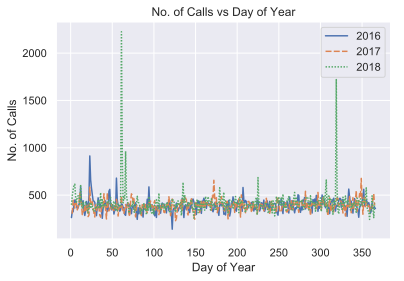

In [11]:
yearByDay = pd.pivot_table(df, values='timeStamp', index=df.timeStamp.dt.year , columns=df.timeStamp.dt.dayofyear, aggfunc=np.count_nonzero)
yearByDay = yearByDay[yearByDay.index != 2015]
yearByDay = yearByDay[yearByDay.index != 2019]
yearByDay = yearByDay.transpose()
ax = sns.lineplot(data=yearByDay)
ax.set(xlabel='Day of Year',ylabel='No. of Calls')
ax.set_title('No. of Calls vs Day of Year')

Plotting number of calls vs hour

Text(0.5, 1.0, 'No. of Calls by Hour of Day')

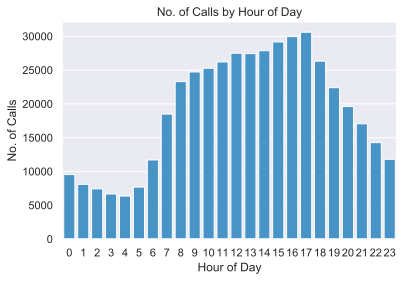

In [12]:
flatui = ["#3498db"]
ax = sns.countplot(df['timeStamp'].dt.hour,palette=flatui,color="seagreen");
ax.set(xlabel="Hour of Day", ylabel="No. of Calls")
ax.set_title("No. of Calls by Hour of Day")

Number of Calls vs Day of Week

[Text(0, 0.5, 'No. of Calls'), Text(0.5, 0, 'Day of Week')]

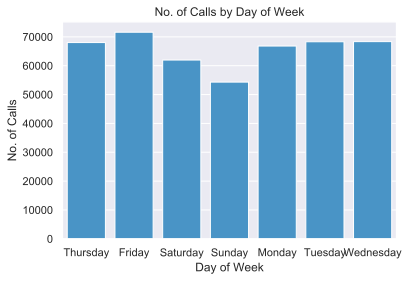

In [13]:
ax = sns.countplot(df['timeStamp'].dt.day_name(),palette=flatui,color="seagreen");
ax.set_title("No. of Calls by Day of Week")
ax.set(xlabel="Day of Week", ylabel="No. of Calls")

## Finding out simultaneous calls

The code below finds the calls occuring simultaneously. Note code assumes all calls are 2 minutes long

In [14]:
df['callCount'] = 0
duration = pd.Timedelta(pd.offsets.Minute(2))

In [15]:
def find_count(x):
    return  ((df['timeStamp'].searchsorted(x+duration)) - (df['timeStamp'].searchsorted(x-duration)))

In [16]:
z = df['timeStamp'].swifter.apply(find_count)

In [17]:
df['callCount'] = z

In [18]:
df = df.set_index('timeStamp')

In [19]:
df.tail(20)

callCount
timeStamp                     
2019-02-06 09:37:01          2
2019-02-06 09:42:00          3
2019-02-06 09:42:00          3
2019-02-06 09:42:01          3
2019-02-06 09:47:00          2
2019-02-06 09:47:01          2
2019-02-06 09:57:00          1
2019-02-06 10:07:01          1
2019-02-06 10:11:01          2
2019-02-06 10:12:00          2
2019-02-06 10:17:00          2
2019-02-06 10:17:01          2
2019-02-06 10:22:00          1
2019-02-06 10:27:00          1
2019-02-06 10:32:01          2
2019-02-06 10:32:02          2
2019-02-06 10:37:01          1
2019-02-06 10:42:01          1
2019-02-06 10:46:01          2
2019-02-06 10:47:00          2

Finding the number of calls for every day in each month

In [20]:
monthVsDayCount = pd.pivot_table(df, values='callCount', index=df.index.month , columns=df.index.day, aggfunc=np.count_nonzero)
monthVsDayCount.head()

timeStamp      1       2       3       4       5       6       7       8   \
timeStamp                                                                   
1          1262.0  1501.0  1744.0  1862.0  1805.0  1604.0  1654.0  1588.0   
2          1685.0  1761.0  1500.0  1523.0  1655.0  1218.0  1066.0  1117.0   
3          1173.0  3118.0  1649.0  1122.0  1088.0  1115.0  1744.0  1274.0   
4          1089.0  1096.0  1317.0  1323.0  1108.0  1226.0  1084.0  1056.0   
5           886.0  1264.0  1206.0  1172.0  1094.0   962.0  1033.0  1053.0   

timeStamp      9       10  ...      22      23      24      25      26  \
timeStamp                  ...                                           
1          1651.0  1695.0  ...  1674.0  2367.0  1939.0  1844.0  1673.0   
2          1306.0  1211.0  ...  1081.0  1111.0  1488.0  1179.0  1077.0   
3          1224.0  1224.0  ...  1121.0  1167.0  1122.0   970.0   951.0   
4          1000.0   997.0  ...  1063.0  1093.0  1005.0  1194.0  1247.0   
5          1191.0  1190.0  ...  1113.0  1204.0  1216.0  1368.0  1185.0   

timeStamp      27      28      29      30      31  
timeStamp                                          
1          1449.0  1503.0  1514.0  1568.0  1388.0  
2          1159.0  1075.0   343.0     NaN     NaN  
3          1007.0  1151.0  1191.0  1048.0  1124.0  
4          1089.0  1293.0  1059.0   976.0     NaN  
5          1115.0   924.0  1031.0  1076.0  1246.0  

[5 rows x 31 columns]

[Text(30.5, 0.5, 'Month'), Text(0.5, 12.5, 'Day of Month')]

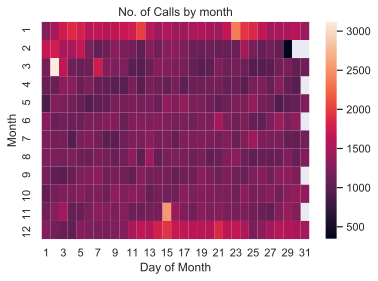

In [21]:
ax = sns.heatmap(monthVsDayCount)
ax.set_title('No. of Calls by month')
ax.set(xlabel="Day of Month", ylabel="Month")

In [22]:
df.callCount.describe()

count    459399.000000
mean          3.040102
std           2.332006
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          37.000000
Name: callCount, dtype: float64

We can see above that there are some outliers with very high call count. 

## Removing Outliers
This line below outliers in the data by ignoring cells that have a zscore less than 3

In [23]:
df = df[(np.abs(stats.zscore(df['callCount'])) < 3)]

In [24]:
df.callCount.describe()

count    454694.000000
mean          2.883346
std           1.642356
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          10.000000
Name: callCount, dtype: float64

In [25]:
dayoweekVsHour = pd.pivot_table(df, values='callCount', index=df.index.day_name() , columns=df.index.hour, aggfunc=np.mean)

In [26]:
dayoweekVsHour.head()

timeStamp        0         1         2         3         4         5   \
timeStamp                                                               
Friday     1.861154  1.747996  1.686058  1.623932  1.567474  1.906618   
Monday     1.996224  1.716839  1.646872  1.680180  1.625000  1.826124   
Saturday   2.209080  2.100140  1.848392  1.789286  1.736634  1.780209   
Sunday     2.077014  2.055707  1.971098  1.826050  1.796154  1.804326   
Thursday   1.829787  1.634921  1.692153  1.587666  1.517606  2.041145   

timeStamp        6         7         8         9   ...        14        15  \
timeStamp                                          ...                       
Friday     2.156951  2.630258  2.903226  3.025222  ...  3.334975  3.585334   
Monday     2.253552  2.854188  3.171525  3.310876  ...  3.177630  3.366800   
Saturday   1.868545  2.222287  2.545261  2.852568  ...  3.204606  3.144678   
Sunday     1.881811  2.226779  2.363416  2.574361  ...  2.851715  2.751617   
Thursday   2.274176  2.857855  3.168224  3.080851  ...  3.195853  3.387755   

timeStamp        16        17        18        19        20        21  \
timeStamp                                                               
Friday     3.648183  3.630015  3.197762  2.985857  2.727121  2.640737   
Monday     3.456754  3.434646  3.128071  2.789166  2.588391  2.278424   
Saturday   3.145626  3.079191  3.063867  2.902693  2.754962  2.597494   
Sunday     2.747560  2.853291  2.750917  2.634334  2.545768  2.227778   
Thursday   3.378749  3.614445  3.207985  2.844278  2.569097  2.402851   

timeStamp        22        23  
timeStamp                      
Friday     2.456882  2.460241  
Monday     2.130119  1.864057  
Saturday   2.336555  2.241544  
Sunday     2.145684  2.112811  
Thursday   2.118522  2.006120  

[5 rows x 24 columns]

[Text(30.453125, 0.5, 'Month'), Text(0.5, 12.5, 'Day of Month')]

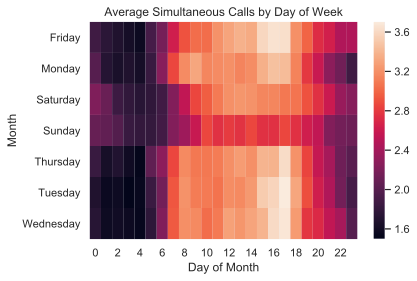

In [27]:
ax = sns.heatmap(dayoweekVsHour,xticklabels=2)
ax.set_title('Average Simultaneous Calls by Day of Week')
ax.set(xlabel="Day of Month", ylabel="Month")

Text(0.5, 1.0, 'Average Simultaneous Calls by Day of Week')

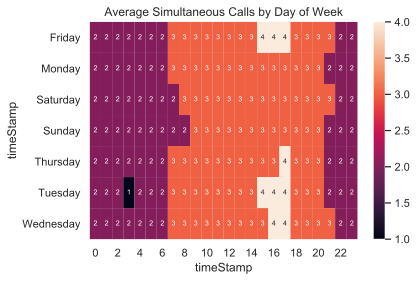

In [28]:
ax = sns.heatmap(dayoweekVsHour.apply(lambda x:np.round(x,0)),xticklabels=2,annot=True, annot_kws={"size": 7})
ax.set_title('Average Simultaneous Calls by Day of Week')

[Text(30.453125, 0.5, 'Month'), Text(0.5, 12.5, 'Day of Month')]

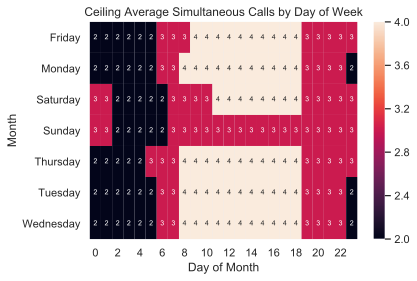

In [29]:
ax = sns.heatmap(dayoweekVsHour.apply(np.ceil),xticklabels=2,annot=True, annot_kws={"size": 7})
ax.set_title('Ceiling Average Simultaneous Calls by Day of Week')
ax.set(xlabel="Day of Month", ylabel="Month")

In [30]:
monthVsDay = pd.pivot_table(df, values='callCount', index=df.index.month , columns=df.index.day, aggfunc=np.mean)

In [31]:
monthVsDay.head()

timeStamp        1         2         3         4         5         6   \
timeStamp                                                               
1          2.302694  2.642905  3.125508  3.240951  3.132964  2.987531   
2          2.973684  3.099542  2.708000  2.866399  2.938369  2.729064   
3          2.860188  4.171352  3.748332  2.695187  2.634191  2.817040   
4          2.690167  2.692166  3.227031  3.168556  2.736462  3.030995   
5          2.801354  2.956487  2.922428  2.822526  2.645338  2.565591   

timeStamp        7         8         9         10  ...        22        23  \
timeStamp                                          ...                       
1          3.030230  2.875315  2.895821  3.023599  ...  2.934289  3.749680   
2          2.699812  2.713518  3.163859  2.996697  ...  2.559667  2.726373   
3          3.747580  2.984301  2.799020  2.934641  ...  2.828724  2.677806   
4          2.706642  2.492424  2.544000  2.717151  ...  2.475071  2.730101   
5          2.647628  2.642308  2.964736  2.933613  ...  2.800539  2.835548   

timeStamp        24        25        26        27        28        29  \
timeStamp                                                               
1          3.227178  3.085683  2.995187  2.605245  2.732535  2.962366   
2          3.567760  2.742154  2.805014  2.715272  2.572093  2.422741   
3          2.631016  2.402062  2.629863  2.600794  2.900956  2.914358   
4          2.524378  2.956449  3.014435  2.731864  3.004684  2.539188   
5          2.883224  3.100877  2.702954  2.661883  2.508658  2.650824   

timeStamp        30        31  
timeStamp                      
1          2.746173  2.609510  
2               NaN       NaN  
3          2.603053  2.718861  
4          2.543033       NaN  
5          2.776022  2.922953  

[5 rows x 31 columns]

Text(0.5, 1.0, 'Average Simultaneous Calls by Month')

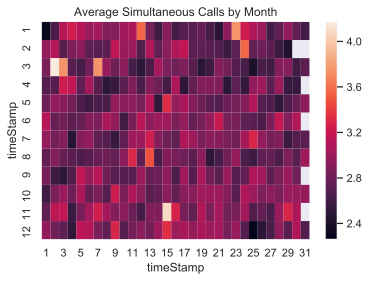

In [32]:
ax = sns.heatmap(monthVsDay)
ax.set_title('Average Simultaneous Calls by Month')